In [17]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import pandas as pd
from scipy.interpolate import PchipInterpolator

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cmcrameri.cm as cm


In [2]:
import utils.load_grid as lg
import feathers
from proteus.utils.plot import get_colour
from proteus.atmos_clim.common import read_atmosphere_data
from proteus.interior.wrapper import read_interior_data

from proteus.utils.constants import R_earth, M_earth

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'
# %matplotlib widget

In [4]:
outdir = "data/shared/l98d_chemstudy/"
help = pd.read_csv(outdir+"runtime_helpfile.csv", sep=r"\s+")

age_start = float(help["age_star"].iloc[0])

print("Done")

Done


### Make plots

In [5]:
print("Psurf = %.2f bar"%(help["P_surf"].iloc[-1]))
print("rho = %.2f g/cc"%(help["rho_obs"].iloc[-1]/1e3))

Psurf = 37431.13 bar
rho = 3.46 g/cc


In [10]:
# load netcdfs
print(outdir)
t_arr  = lg.get_nc_years(outdir)
nc_arr = read_atmosphere_data(outdir, t_arr, extra_keys=["fl_cnvct","tmpl","rl"])
# js_arr = read_interior_data(outdir, "spider", t_arr)

data/shared/l98d_chemstudy/


Total (start): 11.79
Total (end): 8.68
Total (diff): -3.11
Total (rel chng): -26.39 %


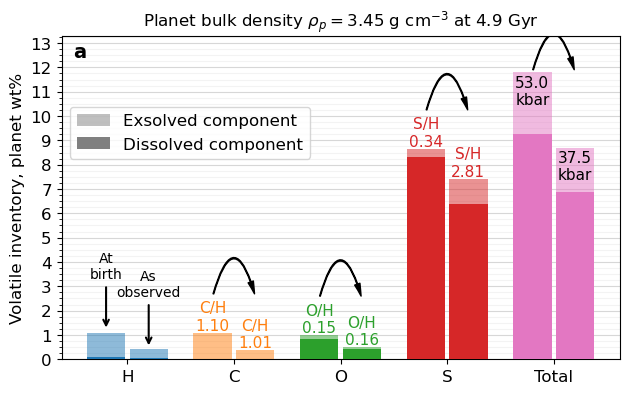

In [26]:
figscale = 1.2
fig, ax = plt.subplots(1,1, figsize=(6*figscale, 3.5*figscale))

elems = ['H', 'C', 'O', 'S']

dx = 2.5
dc = 1.0
bw = 0.9
ht = "///"
fs = 11

i0 = 5
i1 = -2

# totals
t_liq_0 = 0.0
t_atm_0 = 0.0
t_liq_1 = 0.0
t_atm_1 = 0.0

def _add_arrow(x,y):
    style = "Simple, tail_width=0.5, head_width=4, head_length=9"
    kw = dict(arrowstyle=style, color="k", zorder=5)

    a1 = patches.FancyArrowPatch((x-0.5,y), (x+0.5,y),
                                connectionstyle="arc3,rad=-1.8", **kw)
    ax.add_patch(a1)


for i,e in enumerate(elems):

    col = "C"+str(i)
    al = 0.5

    # start of simulation
    yunit = help["M_planet"].iloc[i0] / 100

    e_liq_0 = help[e+"_kg_liquid"].iloc[i0] / yunit
    ax.bar(i*dx, e_liq_0,  color=col, width=bw, zorder=5)
    t_liq_0 += e_liq_0

    e_atm_0 = help[e+"_kg_atm"].iloc[i0] / yunit
    ax.bar(i*dx, e_atm_0, bottom=e_liq_0, color=col, width=bw, zorder=5, alpha=al)
    t_atm_0 += e_atm_0

    if e != 'H':
        XH = help[e+"_kg_atm"].iloc[i0] / help["H_kg_atm"].iloc[i0]
        ax.text(i*dx, e_atm_0+e_liq_0, "%s/H\n%.2f"%(e,XH),
                    ha='center', va='bottom', fontsize=fs, color=col, zorder=8)


    # end of simulation
    yunit = help["M_planet"].iloc[i1] / 100

    e_liq_1 = help[e+"_kg_liquid"].iloc[i1] / yunit
    ax.bar(i*dx+dc, e_liq_1,  color=col, width=bw, zorder=5)
    t_liq_1 += e_liq_1

    e_atm_1 = help[e+"_kg_atm"].iloc[i1] / yunit
    ax.bar(i*dx+dc, e_atm_1, bottom=e_liq_1, color=col, alpha=al, width=bw, zorder=5)
    t_atm_1 += e_atm_1

    if e != 'H':
        XH = help[e+"_kg_atm"].iloc[i1] / help["H_kg_atm"].iloc[i1]
        ax.text(i*dx+dc, e_atm_1+e_liq_1, "%s/H\n%.2f"%(e,XH),
                    ha='center', va='bottom', fontsize=fs, color=col, zorder=8)

    # add arrow
    if i > 0:
        x = i*dx+dc/2
        y = e_atm_0+e_liq_0 + 1.5
        _add_arrow(x,y)

# total
col = "tab:pink"
#   start
x = len(elems)*dx
ax.bar(x, t_liq_0,                    color=col, zorder=5, width=bw)
ax.bar(x, t_atm_0, bottom=t_liq_0,    color=col, zorder=5, width=bw, alpha=al)
t_tot_0 = t_atm_0 + t_liq_0
ax.text(x, t_tot_0*0.99, "%.1f\nkbar"%(help["P_surf"].iloc[i0]/1e3),
                    ha='center', va='top', fontsize=fs, color='k', zorder=8)

y = t_tot_0
_add_arrow(x+dc/2,y)

print("Total (start): %.2f"%(t_tot_0))


#   end
x = len(elems)*dx+dc
ax.bar(x, t_liq_1,                 color=col, zorder=5, width=bw)
ax.bar(x, t_atm_1, bottom=t_liq_1, color=col, zorder=5, width=bw, alpha=al)
t_tot_1 = t_atm_1 + t_liq_1
ax.text(x, t_tot_1*0.99, "%.1f\nkbar"%(help["P_surf"].iloc[i1]/1e3),
                    ha='center', va='top', fontsize=fs, color='k', zorder=8)
print("Total (end): %.2f"%(t_tot_1))
print("Total (diff): %.2f"%(t_tot_1-t_tot_0))
print("Total (rel chng): %.2f %%"%((t_tot_1-t_tot_0)/t_tot_0*100))

# legend
col = 'grey'
ax.bar([0],[0], color=col, alpha=al, label="Exsolved component")
ax.bar([0],[0], color=col,  label="Dissolved component")

# annotate
yb = help["H_kg_total"].iloc[i0] / help["M_planet"].iloc[i0] * 100 * 1.1
ax.annotate("At\nbirth",    xy=(0, yb), xytext=(0, yb+2), arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=10, ha='center', va='bottom')
yb = help["H_kg_total"].iloc[i1] / help["M_planet"].iloc[i1] * 100 * 1.1
ax.annotate("As\nobserved", xy=(1, yb), xytext=(1, yb+2), arrowprops=dict(arrowstyle="->", lw=1.5), fontsize=10, ha='center', va='bottom')

# decorate
ax.set_xticks(np.arange(0,(len(elems)+1)*dx, dx)+dc/2)
ax.set_xticklabels(elems + ["Total"])
ax.set_ylabel("Volatile inventory, planet wt%")

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.grid(axis='y', zorder=-2, alpha=0.5, which='major')

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.grid(axis='y', zorder=-2, alpha=0.15, which='minor')

ax.set_ylim(bottom=0,top=t_atm_0+t_liq_0+1.5)

ax.text(0.02, 0.98, "a", ha='left', va='top', fontsize=14, transform=ax.transAxes, fontweight='bold')

ax.legend(loc='center left', bbox_to_anchor=(0.0, 0.7))

rho = help["rho_obs"].iloc[i1] * 1e-3
age = help["age_star"].iloc[i1] * 1e-9
ax.set_title(r"Planet bulk density $\rho_p=$%.2f g cm$^{-3}$ at %.1f Gyr"%(rho,age), fontsize=12)

plt.show()
fig.savefig("output/fig_inventory.pdf", bbox_inches='tight', dpi=300)

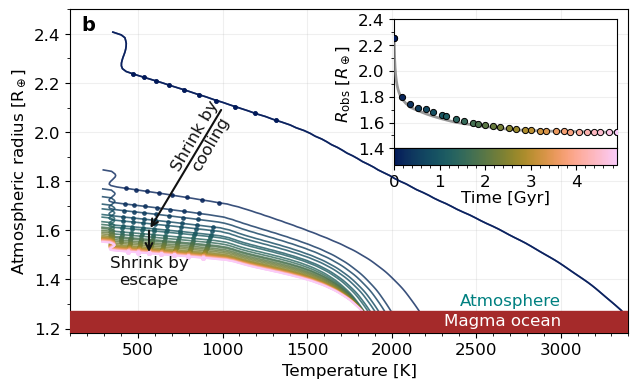

In [16]:
figscale = 1.2
fig, ax = plt.subplots(1,1, figsize=(6*figscale, 3.5*figscale))


axi_h = 0.4
axi_w = 0.4
axi_y = 0.03
axi_x = 0.02
axi_c = 0.05
axi = ax.inset_axes((1-axi_w - axi_x, 1-axi_h - axi_y,         axi_w, axi_h), )
axc = ax.inset_axes((1-axi_w - axi_x, 1-axi_h - axi_y - axi_c, axi_w, axi_c), )

t_gyr = t_arr / 1e9
vmin, vmax = 0, np.amax(t_gyr)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cm.batlow, norm=norm)
sm.set_array([])


R_int = help["R_int"].iloc[-1] / R_earth

# time array
time_plt = np.linspace(vmin, vmax, 30)
idx_plt  = [0] + [np.argmin(np.abs(t_gyr - time)) for time in time_plt] + [len(t_gyr)-1]
idx_plt  = sorted(idx_plt)

# plot samples
for j,i in enumerate(idx_plt):

    atm_t = nc_arr[i]["t"][::-1]
    atm_r = nc_arr[i]["r"][::-1] / R_earth

    atm_rl = nc_arr[i]["rl"] / R_earth
    atm_fl = nc_arr[i]["fl_cnvct"]
    atm_tl = nc_arr[i]["tmpl"]

    time = t_gyr[i]

    color = sm.to_rgba(time)
    al = 0.8
    lw = 1.2

    # profile
    yy = np.linspace(atm_r[0], atm_r[-1], 100)
    xx = PchipInterpolator(atm_r, atm_t)(yy)
    ax.plot(xx,yy, color=color, lw=lw, alpha=al, zorder=5+j)

    # convection mask
    mm = np.argwhere(atm_fl > 1e-5)
    yy = atm_rl[mm]
    xx = atm_tl[mm]
    ax.scatter(xx,yy, color=color, s=6, alpha=al, zorder=5+j, marker='o')

    # inset scatter point
    axi.scatter(time, help["R_obs"].iloc[i]/R_earth, color=color, s=20, lw=0.7, edgecolor='k', zorder=5+j)

# plot R_obs over time, line
axi.plot(help["Time"]/1e9, help["R_obs"]/R_earth, color='grey', lw=2, alpha=0.8, zorder=4)

# arrows
x = 565
c = "#111111"
yb = 1.5
ax.annotate("", (x,1.6), (1000,2.1), zorder=99,
                 arrowprops=dict(arrowstyle="->", lw=1.5, color=c,))
ax.text(885, 1.97, "Shrink by\ncooling", rotation=60, ha='center', va='center',
            fontsize=12, color=c, zorder=99)
ax.annotate("", (x,yb), (x,1.61), zorder=99,
                 arrowprops=dict(arrowstyle="->", lw=1.5, color=c,))
ax.text(x, yb, "Shrink by\nescape", rotation=0, ha='center', va='top',
            fontsize=12, color=c, zorder=99)

# main axis labels
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Atmospheric radius [R$_\oplus$]")
ax.set_xlim(left=100, right=3400)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(500))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(100))
ax.set_ylim(bottom=R_int-0.09, top=2.5)

# ground
ax.fill_between(ax.get_xlim(), ax.get_ylim()[0], R_int,
                    zorder=50, color='brown', hatch='//')
ax.text(3000, R_int-0.01, "Magma ocean",  va='top',   ha='right', zorder=55, color='w')
ax.text(3000, R_int+0.01, "Atmosphere",  va='bottom', ha='right', zorder=55, color='teal')

# main and inset axes
for axx in (ax, axi):
    axx.grid(alpha=0.2, zorder=-2)
    axx.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    axx.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

# inset axis
axi.set_ylabel(r"$R_\text{obs}$ $[R_\oplus]$")
axi.set_xticks([])
axi.set_xlim(vmin, vmax)
axi.set_ylim(bottom=1.4, top=2.4)

# colorbar
cb = fig.colorbar(sm, cax=axc, orientation='horizontal')
cb.ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
cb.ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
cb.ax.set_xlabel("Time [Gyr]", labelpad=0.5)

# panel label
ax.text(0.02, 0.98, "b", ha='left', va='top', fontsize=14, transform=ax.transAxes, fontweight='bold')

plt.show()
fig.savefig("output/fig_contract.pdf", bbox_inches='tight', dpi=300)